# Восстановление золота из руды

Необходимо построить модель, предсказывающую коэффициент восстановления золота из руды. Анализ и построение модели производится на основании данных о содержании золота и других металлов в исходной руде и "полуфабрикатах" каждого этапа производства, а также данных с параметрами очистки на каждом этапе

## Подготовка данных

Сделаем все необходимые импорты

In [383]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.preprocessing import StandardScaler
RANDOM_STATE = 1234

<h3>Открытие файлов и предварительный анализ данных</h3>

In [384]:
def open_file_print_info(filename):
    print('Данные о файле: ',filename)
    data = pd.read_csv(filename)
    display(data.head(5))
    print('Общая информация: ')
    print(data.info())
    return data

gold_recovery_train = open_file_print_info('/datasets/gold_recovery_train.csv')    

Данные о файле:  /datasets/gold_recovery_train.csv


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


Общая информация: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depr

Можно видеть, что в данных достаточно большое количество пропусков, в разных столбцах количество пропусков очень сильно отличается. Однако, из условия задачи известен тот факт, что соседние по времени параметры часто похожи. Этот факт можно использовать для заполнения пропусков. Заполнение пропусков осуществим немного позднее.
Осуществим расчет признака rougher.output.recovery по имеющейся формуле

Проверим, насколько правильно расчитана метрика recovery. Посчитаем ее для данных без пропусков:

In [385]:
def count_recovery(data): #функция для расчета reccovery 
    try:
        recovery = ((data['rougher.output.concentrate_au'] * 
                (data['rougher.input.feed_au'] - data['rougher.output.tail_au'])) / (data['rougher.input.feed_au'] * (data['rougher.output.concentrate_au'] - data['rougher.output.tail_au']))) * 100
    except:
        recovery = np.nan
    return recovery

#создадим вспомогательный датафрейм, в котором расчитаем recovery по непропущенным в соответствующих столбцах данным
gold_recovery_train_clean = gold_recovery_train[['rougher.output.concentrate_au','rougher.input.feed_au','rougher.output.tail_au','rougher.output.recovery']].dropna()
gold_recovery_train_clean['rougher.output.recovery_counted'] = gold_recovery_train_clean.apply(lambda x:count_recovery(x),axis =1)
print("Размер таблицы без пропусков в столбцах 'rougher.output.concentrate_au','rougher.input.feed_au','rougher.output.tail_au','rougher.output.recovery':", gold_recovery_train_clean.shape[0])
display(gold_recovery_train_clean.head(3))
print()
print('\033[1m' , 'MAE для исходных и расчетных данных:' +'\033[0m' +' ', mean_absolute_error(gold_recovery_train_clean['rougher.output.recovery'],gold_recovery_train_clean['rougher.output.recovery_counted']))

Размер таблицы без пропусков в столбцах 'rougher.output.concentrate_au','rougher.input.feed_au','rougher.output.tail_au','rougher.output.recovery': 14287


,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au,rougher.output.recovery,rougher.output.recovery_counted
0,19.793808,6.486150,1.170244,87.107763,87.107763
1,20.050975,6.478583,1.184827,86.843261,86.843261
2,19.737170,6.362222,1.162562,86.842308,86.842308



 MAE для исходных и расчетных данных:  9.444891926100695e-15


Расчетные значения столбца rougher.output.recovery_counted крайне мало отличаются от табличных значений в столбце rougher.output.recovery (значение MAE очень близко к нулю). Это значит, что значения в столбце rougher.output.recovery можно использовать в построении модели.

Откроем файл с тестовыми данными:

In [386]:
gold_recovery_test = open_file_print_info('/datasets/gold_recovery_test.csv')

Данные о файле:  /datasets/gold_recovery_test.csv


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


Общая информация: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null

В тестовых данных отсутсвует информация о выходных данных каждого этапа: коцентрат веществ (ag, au, sol, pb), а также отвальные хвосты. Имеется только информация о входных концентрациях, а также параметры каждого этапа. Модель должна расчитывать recovery, основывась на этих данных

In [387]:
gold_recovery_full = open_file_print_info('/datasets/gold_recovery_full.csv')
print()
print('Количество пропущенных значений в стодлбце final.output.recovery в FULL датафрейме: ', gold_recovery_full['final.output.recovery'].isnull().sum())
print('Количество пропущенных значений в стодлбце rouger.output.recovery в FULL датафрейме: ', gold_recovery_full['rougher.output.recovery'].isna().sum())
print('Количество пропущенных значений в стодлбце final.output.recovery в TRAIN датафрейме: ', gold_recovery_train['final.output.recovery'].isna().sum())
print('Количество пропущенных значений в стодлбце rouger.output.recovery в TRAIN датафрейме: ', gold_recovery_train['rougher.output.recovery'].isna().sum())

Данные о файле:  /datasets/gold_recovery_full.csv


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


Общая информация: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depr

В общей таблице также пропущено достаточно большое количество значений, в том числе в столбцах recovery. Однако, можно видеть, что количество пропущенных значений в этих столбцах больше, чем количество пропущенных значений в аналогичных столбцах в TRAIN датафрейме. Это говорит о том, что, скорее всего, пропущены и те значения, которые должны послужить для проверки модели (значения из test). <br>
Ввиду того, что расчетные значения recovery совпадают со значениями датафрейма, то можно применить формулу для заполнения пропущенных значений. <br>
Пропуски в остальных столбцах можно заполнить на основании того факта, что соседние по времени парамеры часто похожи: пропуск можно заполнять как среднее значение парметра в предшествующей и последующей строке.<br>
Проведем предобработку данных

<h3>Предобработка данных</h3>


Заполним пропущенные значения в датасетах _train и _test на основе данных из full. Напишем функцию для замены:

In [388]:
def fill_nulls_from_full(data,data_full,index_column):   
    data = data.set_index(index_column)
    data_full = data_full.set_index(index_column)
    total_sum = 0
    for column in data:
        null_count_before = data[column].isna().sum().sum()
        data[column] = data[column].fillna(data_full[column])
        null_count_after = data[column].isna().sum().sum()
        diff = null_count_before - null_count_after
        total_sum += diff
    data = data.reset_index()
    data_full = data_full.reset_index()
    print('Всего заменено пропусков  на основе данных из _full датасета: ',total_sum)
    return data

Напишем функцию, которая будет заполнять пропущенное значение в столбце методом интерполяции

In [389]:
def fill_nulls_by_columns(data): 
    column_list = []
    for column in data:
        if (column != 'final.output.recovery') and (column != 'rougher.output.recovery'):
            column_list.append(column)
    data = data.set_index(pd.DatetimeIndex(data['date']))
    data[column_list] = data[column_list].interpolate(method = 'time')
    #data = data.drop('date',axis = 1)
   # data = data.reset_index()
    return data    

Напишем функцкцию, которая для каждой колонки считает минимальное и максимальное значение

Проверим количество строк в датафреймах full, train и test, а также количество пропусков в них:

In [390]:
print('Все ли строки из train и test есть в full:',gold_recovery_full.shape[0] - gold_recovery_train.shape[0] - gold_recovery_test.shape[0] )
dates_train = gold_recovery_train['date']
dates_test = gold_recovery_test['date']
print('Количество пропусков в full в строках, соответсвтующих train',gold_recovery_full.query('date in @dates_train').isna().sum().sum())
print('Количество пропусков в train',gold_recovery_train.isna().sum().sum())
print('Количество пропусков в full в строках, соответсвтующих test',gold_recovery_full.query('date in @dates_test').isna().sum().sum())
print('Количество пропусков в test',gold_recovery_test.isna().sum().sum())
gold_recovery_full_test = gold_recovery_full.query('date in @dates_test')

Все ли строки из train и test есть в full: 0
Количество пропусков в full в строках, соответсвтующих train 30320
Количество пропусков в train 30320
Количество пропусков в full в строках, соответсвтующих test 6267
Количество пропусков в test 2360


Можно видеть, что full датасет состоит из строк, соответствующих train и test. Количество пропусков в full в строках, соответствующих train, точно такое же, как и в строках train датасета. А в строках, соответствующих test датасету их почти в 3 раза больше, чем в самом test датасете (скорее всего, потому что в full датасете больше столбцов). Вероятнее всего, зменить пропуски на основе данных из full датасета не получится. Однако, попробуем применить функцию заполнения пропусков на основе full датасета.

<h4>Предобработка датафрейма gold_recovery_train</h4>

In [391]:
#проверим, можно ли заменить пропущенные значения значениями из gold_recovery_full
gold_recovery_train = fill_nulls_from_full(gold_recovery_train,gold_recovery_full,'date')
#чтобы точно быть уверенным, что подряд идут близкие по времени измерения, отсортируем датафрейм по дате-времени:
gold_recovery_train = gold_recovery_train.sort_values(by='date')  
#заполняем пропуски в целевых колонках
gold_recovery_train['rougher.output.recovery'] = np.where(np.isnan(gold_recovery_train['rougher.output.recovery']) == True,gold_recovery_train.apply(lambda x:count_recovery(x),axis =1),gold_recovery_train['rougher.output.recovery'])
gold_recovery_train['final.output.recovery'] = np.where(np.isnan(gold_recovery_train['final.output.recovery']) == True,gold_recovery_train.apply(lambda x:count_recovery(x),axis =1),gold_recovery_train['final.output.recovery'])
#заполняем пропуски во всех колонках, кроме целевых
gold_recovery_train = fill_nulls_by_columns(gold_recovery_train)
print('Общая информация о датафрейме после замены пропусков')
gold_recovery_train.info()

Всего заменено пропусков  на основе данных из _full датасета:  0
Общая информация о датафрейме после замены пропусков
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16860 non-null float64
final.output.concentrate_pb                           16860 non-null float64
final.output.concentrate_sol                          16860 non-null float64
final.output.concentrate_au                           16860 non-null float64
final.output.recovery                                 15513 non-null float64
final.output.tail_ag                                  16860 non-null float64
final.output.tail_pb                                  16860 non-null float64
final.output.tail_sol                                 16860 non-null float64
final.output.tail_au                          

Можно видеть, что в целевых признаках остались пропущенные значения, так как их корректировать мы никак не можем,  просто удалим строки с пропущенными значениями

In [392]:
#удалим пропущенные значения в тренировочной таблице и выведем общую информацию о таблице после преобразований
gold_recovery_train = gold_recovery_train.dropna()
gold_recovery_train.shape

(14547, 87)

Убедимся, что в столбцах, содержащих информацию о концентрации веществ, нет отрицательных значений:


In [393]:
def print_describe(data,metal):
    columns = ['final.output.concentrate_'+metal,'final.output.tail_'+metal,'primary_cleaner.output.concentrate_'+metal,'primary_cleaner.output.tail_'+metal,'rougher.output.concentrate_'+metal,'rougher.output.tail_'+metal,'rougher.input.feed_'+metal]
    print('Минимальные значения для столбцов, содержащих сведения о концентрации металлов, для '+metal)
    display(data[columns].min())
    print()

metals = ['au','ag','pb','sol']
for metal in metals:
    print_describe(gold_recovery_train, metal) 

Минимальные значения для столбцов, содержащих сведения о концентрации металлов, для au


final.output.concentrate_au              0.000000
final.output.tail_au                     0.000000
primary_cleaner.output.concentrate_au    0.000000
primary_cleaner.output.tail_au           0.000000
rougher.output.concentrate_au            0.000000
rougher.output.tail_au                   0.020676
rougher.input.feed_au                    0.010000
dtype: float64


Минимальные значения для столбцов, содержащих сведения о концентрации металлов, для ag


final.output.concentrate_ag              0.000000
final.output.tail_ag                     0.000000
primary_cleaner.output.concentrate_ag    0.000000
primary_cleaner.output.tail_ag           0.000000
rougher.output.concentrate_ag            0.000000
rougher.output.tail_ag                   0.594562
rougher.input.feed_ag                    0.010000
dtype: float64


Минимальные значения для столбцов, содержащих сведения о концентрации металлов, для pb


final.output.concentrate_pb              0.000000
final.output.tail_pb                     0.000000
primary_cleaner.output.concentrate_pb    0.000000
primary_cleaner.output.tail_pb           0.000000
rougher.output.concentrate_pb            0.000000
rougher.output.tail_pb                   0.007566
rougher.input.feed_pb                    0.008001
dtype: float64


Минимальные значения для столбцов, содержащих сведения о концентрации металлов, для sol


final.output.concentrate_sol               0.000000
final.output.tail_sol                      0.000000
primary_cleaner.output.concentrate_sol     0.000000
primary_cleaner.output.tail_sol            0.000000
rougher.output.concentrate_sol             0.000000
rougher.output.tail_sol                   10.014648
rougher.input.feed_sol                     0.000000
dtype: float64

как можно видеть, отрицательных минимальных значений в этих столбцах нет

<b>Вывод:</b><br>
Осуществлена замена пропущенных значений: в _full датасете не оказалось строк, на основании которых можно было бы осуществить замену. Пропуски в столбцах (за исключением столбцов recovery) заполнены на основании на основании данных ближайших соседей (методом интерполяции). Все строки, где recovery пропущены, были удалены. <br>
Проверены значения в столбцах .concentrate. на отсутствие отрицательных значений.

<h4>Преобработка датафрейма gold_recovery_test</h4>

In [394]:
gold_recovery_test = fill_nulls_from_full(gold_recovery_test,gold_recovery_full,'date')
#чтобы точно быть уверенным, что подряд идут близкие по времени измерения, отсортируем датафрейм по дате-времени:
gold_recovery_test = gold_recovery_test.sort_values(by='date')                
#заполняем пропуски во всех колонках, кроме целевых
gold_recovery_test = fill_nulls_by_columns(gold_recovery_test)
print(gold_recovery_test.info())

Всего заменено пропусков  на основе данных из _full датасета:  0
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5856 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5856 non-null float64
primary_cleaner.input.depressant              5856 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5856 non-null float64
primary_cleaner.state.floatbank8_a_air        5856 non-null float64
primary_cleaner.state.floatbank8_a_level      5856 non-null float64
primary_cleaner.state.floatbank8_b_air        5856 non-null float64
primary_cleaner.state.floatbank8_b_level      5856 non-null float64
primary_cleaner.state.floatbank8_c_air        5856 non-null float64
primary_cleaner.state.floatbank8_c_level      5856 non-null float64
primary_cleaner.state.floatbank8_d_air       

<b>Вывод</b><br>
Все пропуски заполнены на основании данных из _full датасета (как оказалось, пропущенных значений, которые можно было бы заполнить на основании full датасета, нет) и значений ближайших соседей (методом интерполяции).

<h4>Подготовка датафрейма gold_recovery_full_test на основе gold_recovery_full, содержащего только строки из gold_recovery_test</h4>

In [395]:
dates = gold_recovery_test['date']
gold_recovery_full = gold_recovery_full.sort_values(by='date')                
#заполняем пропуски во всех колонках, кроме целевых
gold_recovery_full_test = gold_recovery_full.query('date in @dates')
print(gold_recovery_full_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5856 entries, 5521 to 17208
Data columns (total 87 columns):
date                                                  5856 non-null object
final.output.concentrate_ag                           5839 non-null float64
final.output.concentrate_pb                           5841 non-null float64
final.output.concentrate_sol                          5841 non-null float64
final.output.concentrate_au                           5841 non-null float64
final.output.recovery                                 5414 non-null float64
final.output.tail_ag                                  5839 non-null float64
final.output.tail_pb                                  5839 non-null float64
final.output.tail_sol                                 5730 non-null float64
final.output.tail_au                                  5841 non-null float64
primary_cleaner.input.sulfate                         5554 non-null float64
primary_cleaner.input.depressant                      

В строках, соответствующих тестовой выборке, также есть пропущенные значния в целевых метриках. Проверим их. 

Как можно видеть, в таблице исходных данных также есть отсутствующие данные в целевых метриках там, где <b>rougher.input.feed_au =0</b>. При тестировании модели сложно будет сравнить полученный результат с NAN, так что удлим эти строки, а заодно и соответсвтующие строки из тестового датафрейма

In [396]:
#убедмся, что пропущенные значения есть только там, где rougher.input.feed_au = 0
print('количество строк с нулевыми входными данными: ',len(gold_recovery_full_test[gold_recovery_full_test["rougher.input.feed_au"] == 0]))
#количество строк соответсвует количеству пропущенных значений
gold_recovery_full_test = gold_recovery_full_test.dropna()
dates_to_check = gold_recovery_full_test['date']
gold_recovery_test = gold_recovery_test.query('date in @dates_to_check')
print('Размер gold_recovery_full_test = ',gold_recovery_full_test.shape[0])
print('Размер gold_recovery_test = ',gold_recovery_test.shape[0])

количество строк с нулевыми входными данными:  369
Размер gold_recovery_full_test =  5077
Размер gold_recovery_test =  5077


Убедимся, что в столбцах, содержащих информацию о концентрации веществ, нет отрицательных значений:

In [397]:
def print_describe(data,metal):
    columns = ['final.output.concentrate_'+metal,'final.output.tail_'+metal,'primary_cleaner.output.concentrate_'+metal,'primary_cleaner.output.tail_'+metal,'rougher.output.concentrate_'+metal,'rougher.output.tail_'+metal,'rougher.input.feed_'+metal]
    print('Минимальные значения для столбцов, содержащих сведения о концентрации металлов, для '+metal)
    display(data[columns].min())
    print()

metals = ['au','ag','pb','sol']
for metal in metals:
    print_describe(gold_recovery_full, metal) 

Минимальные значения для столбцов, содержащих сведения о концентрации металлов, для au


final.output.concentrate_au              0.000000
final.output.tail_au                     0.000000
primary_cleaner.output.concentrate_au    0.000000
primary_cleaner.output.tail_au           0.000000
rougher.output.concentrate_au            0.000000
rougher.output.tail_au                   0.020676
rougher.input.feed_au                    0.000000
dtype: float64


Минимальные значения для столбцов, содержащих сведения о концентрации металлов, для ag


final.output.concentrate_ag              0.000000
final.output.tail_ag                     0.000000
primary_cleaner.output.concentrate_ag    0.000000
primary_cleaner.output.tail_ag           0.000000
rougher.output.concentrate_ag            0.000000
rougher.output.tail_ag                   0.594562
rougher.input.feed_ag                    0.000000
dtype: float64


Минимальные значения для столбцов, содержащих сведения о концентрации металлов, для pb


final.output.concentrate_pb              0.0
final.output.tail_pb                     0.0
primary_cleaner.output.concentrate_pb    0.0
primary_cleaner.output.tail_pb           0.0
rougher.output.concentrate_pb            0.0
rougher.output.tail_pb                   0.0
rougher.input.feed_pb                    0.0
dtype: float64


Минимальные значения для столбцов, содержащих сведения о концентрации металлов, для sol


final.output.concentrate_sol               0.000000
final.output.tail_sol                      0.000000
primary_cleaner.output.concentrate_sol     0.000000
primary_cleaner.output.tail_sol            0.000000
rougher.output.concentrate_sol             0.000000
rougher.output.tail_sol                   10.014648
rougher.input.feed_sol                     0.000000
dtype: float64

<b>Вывод:</b>
Подготовлен датасет gold_recovery_full_test, в котором содержатся целевые признаки для тестового датасета. Из него удалены проущенные значения, также соответствующие строки удалены и из тестового датасета.<br>
Данные готовы к анализу

## Анализ данных

<h3>Анализ изменения концентрации металлов на каждом этапе</h3>

In [398]:
def print_step_diagr(data,metal): #функция для вывода ступенчатой диаграммы изменения концентрации металлов на разных этапах очстки
    columns = ['rougher.input','rougher.output','primary_cleaner.output','final.output']
    data_means_conc = [data['rougher.input.feed_'+metal].mean(),data['rougher.output.concentrate_'+metal].mean(),data['primary_cleaner.output.concentrate_'+metal].mean(),data['final.output.concentrate_'+metal].mean()]
    tail_conc = ' (чистый концентрат)'
    data_means_tail = [data['rougher.input.feed_'+metal].mean(),data['rougher.output.tail_'+metal].mean(),data['primary_cleaner.output.tail_'+metal].mean(),data['final.output.tail_'+metal].mean()]
    tail_tail = ' (отвальные хвосты)'
    #Выводим специльно на разных диаграммах: так нагляднее
    plot_data = pd.DataFrame({'X_col':columns,'Y_col_conc':data_means_conc,'Y_col_tail':data_means_tail})
    plt.step(x = plot_data['X_col'],y=plot_data['Y_col_conc'],where = 'mid',color = 'C0')
    plt.title('Изменение концентрации '+metal+' на различных этапах очистки'+tail_conc)
    plt.xticks(rotation = 45)
    plt.xlabel('Этап')
    plt.ylabel('Средняя концентрация веществ на этапе')
    plt.show()
    plt.step(x = plot_data['X_col'],y=plot_data['Y_col_tail'],where = 'mid',color = 'C1')
    plt.title('Изменение концентрации '+metal+' на различных этапах очистки'+tail_tail)
    plt.xticks(rotation = 45)
    plt.xlabel('Этап')
    plt.ylabel('Средняя концентрация веществ на этапе')
    plt.show()
    
def print_metal_concentration_dynamic_print(data,metal):
    columns = ['rougher.input.feed_'+metal,'rougher.output.concentrate_'+metal,'rougher.output.tail_'+metal,'primary_cleaner.output.concentrate_'+metal,'primary_cleaner.output.tail_'+metal,'secondary_cleaner.output.tail_'+metal,'final.output.concentrate_'+metal,'final.output.tail_'+metal]
    #выведем несколько значений в столбцах с данных о концентрации металлов
    print('Пример значения признаков')
    display(data[columns].head(5))
    #выведем описательную статистику для столбцов с данными о концентрации металлов
    print('Описательные статистики для признаков, содержащих информацию о концентрации металлов на каждом этапе')
    display(data[columns].describe())
    #напечатаем ступенчатую диаграмму изменения среднего объема сырья
    print_step_diagr(data,metal)
    #напечатем тепловую диаграмму матрицы корреляции
    print()
    print('\033[1m'+'Корреляция признаков, содержащих информацию о концентрации '+metal+' на каждом этапе'+'\033[0m')
    sns.heatmap(data[columns].corr(), cmap= sns.color_palette(palette="RdBu"),linewidths=0.5,annot=True)


<h4>Анализ изменения концентрации золота на разных этапах очистки</h4>

Пример значения признаков


,rougher.input.feed_au,rougher.output.concentrate_au,rougher.output.tail_au,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_au,secondary_cleaner.output.tail_au,final.output.concentrate_au,final.output.tail_au
date,,,,,,,,
2016-01-15 00:00:00,6.486150,19.793808,1.170244,34.174427,2.106679,2.606185,42.192020,2.143149
2016-01-15 01:00:00,6.478583,20.050975,1.184827,34.118526,2.353017,2.488248,42.701629,2.224930
2016-01-15 02:00:00,6.362222,19.737170,1.162562,33.969464,2.416800,2.458187,42.657501,2.257889
2016-01-15 03:00:00,6.118189,19.320810,1.079755,28.260743,2.262051,2.322062,42.689819,2.146849
2016-01-15 04:00:00,5.663707,19.216101,1.012642,33.044932,2.277073,2.330448,42.774141,2.055292


Описательные статистики для признаков, содержащих информацию о концентрации металлов на каждом этапе


,rougher.input.feed_au,rougher.output.concentrate_au,rougher.output.tail_au,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_au,secondary_cleaner.output.tail_au,final.output.concentrate_au,final.output.tail_au
count,14547.000000,14547.000000,14547.000000,14547.000000,14547.000000,14547.000000,14547.000000,14547.000000
mean,7.835177,19.142840,1.761855,32.175635,3.865377,4.266524,43.671460,2.910151
std,1.990840,4.332117,0.730830,6.250871,1.680836,2.453742,6.092314,0.934798
min,0.010000,0.000000,0.020676,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.583792,18.286150,1.310091,30.773157,2.867003,3.148966,43.211658,2.360479
50%,7.650635,19.892199,1.744990,33.186986,3.519443,3.988382,44.852638,2.849572
75%,9.073149,21.356620,2.188485,35.292122,4.512585,4.903597,46.160649,3.438466
max,13.126043,28.522811,9.688980,45.933934,18.528821,26.811643,53.611374,8.197408


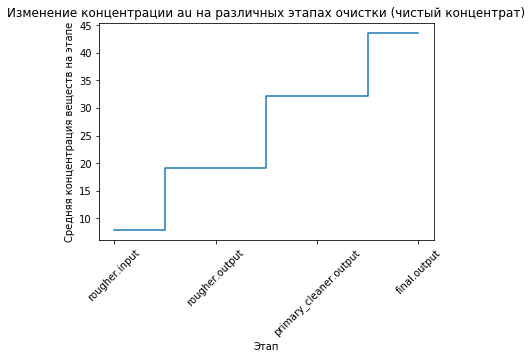

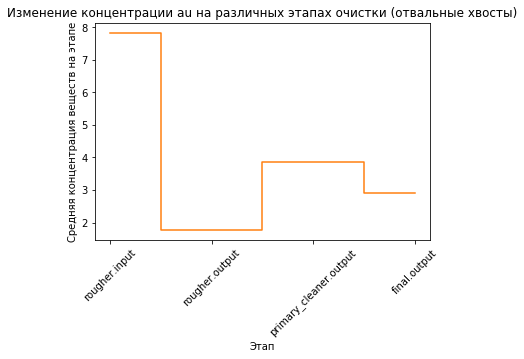


Корреляция признаков, содержащих информацию о концентрации au на каждом этапе


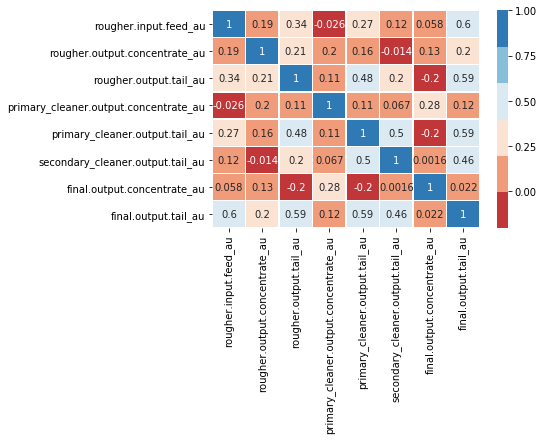

In [399]:
#выведем аналитические данные для золота:    
print_metal_concentration_dynamic_print(gold_recovery_train,'au')

Можно видеть, что концентрация золота в чистом концентрате заметно возрастает на каждом этапе очистки, тогда как в отвальных хвостах наименьшая его концентрация наблюдается только после этапа флотации, в отвальнных хвостах после первичной очистки его доля сильно возрастает. Это значит, что на данном этапе возрастают потери золота, после вторичной очистки концентрация в отвальных хвостах чуть ниже, но все-таки выше, чем после флотации. То есть флотация - наиболее эффективный с точки зрения минимизации потерь этап.<br>
Примечательно, что для всех признаков среднее значение и медиана очень близки. То есть можно предположить, что для данных величин характерно нормальное распределение. Можно видеть, что у различных признаков разное стандартное отклонение (например, у primary_cleaner.output.tail_au стандртное отклонение достаточно большое по сравнению со средним и медианным значением, также максимальное значение данного признака очень высокое, вполне возможно, что это аномалия; у признака primary_cleaner.output.concentrate_au, наборот, значение стандартного отклонения по отношению к среднему и медианному невысоко, то есть у данного признака не такой большой разброс, и максимальное значение не такое высокое, чтобы считать его аномалией). Таким образом можно сказать, что значения признаков распреелены по-разному. Но точно можно видеть, что в признаках, характеризующих чистый концентрат, значение стандартного отклонения не слишком высоко по сравнению со средним и медианным значением,а также максимальные значения не слишком велики, их нельзя назвать аномалиями, в то время как у признков, характеризующих концентрацию металла в отвальных хвостах, достаточно большое значение стандартного отклонения и максимальные значения очень большие. Это говорит о том, что формирование отвальных хвостов очень неравномерно, и здесь могут быть большие потери, а также что концентрация металла в хвостах зависит от каких-то дополнительных факторов.<br>
Можно заметить, что максимальная корреляция наблюдается между признаками rougher.input.feed_au и final.output.tail_au, причем корреляция между этими признаками умеренная, но близкая к сильной. В то время как корреляция между rougher.input.feed_au и final.output.concentrate_au очень слабая. Также можно видеть, что на каждом этапе значения .tail_au и concentrate_au между собой коррелируют довольно слабо, а вот значения все .tail_au на всех этапах коррелируют между собой уже сильнее (свыше 50%). Также можно видеть, что коэффициент корреляции между всеми .concentrate_au также близок к 50%. То есть между всеми "однонаправленными" признаками (всеми .concentrate и всеми .tail) обнаруживается довольно слабая корреляция. Это говорит о том, что здесь достаточно велико влияние еще других факторов (предположительно фактовров .state), при этом концентрация в .concentrate доволно слабо коррелирует с .tail, что говорит об очень большом влиянии других признаков.<br>
Причиной такой слабой корреляции могут быть аномальные значения. Удалив их, можем получить более точный результат.


<h4>Анализ изменения концентрации серебра на разных этапах очистки</h4>

Пример значения признаков


,rougher.input.feed_ag,rougher.output.concentrate_ag,rougher.output.tail_ag,primary_cleaner.output.concentrate_ag,primary_cleaner.output.tail_ag,secondary_cleaner.output.tail_ag,final.output.concentrate_ag,final.output.tail_ag
date,,,,,,,,
2016-01-15 00:00:00,6.100378,11.500771,5.008018,8.547551,14.936526,14.500184,6.055403,10.411962
2016-01-15 01:00:00,6.161113,11.615865,4.955378,8.558743,16.250511,14.265474,6.029369,10.462676
2016-01-15 02:00:00,6.116455,11.695753,4.843460,8.603505,16.491823,14.115662,6.055926,10.507046
2016-01-15 03:00:00,6.043309,11.915047,4.655288,7.221879,16.024359,13.732071,6.047977,10.422762
2016-01-15 04:00:00,6.060915,12.411054,4.552800,9.089428,16.480185,14.079996,6.148599,10.360302


Описательные статистики для признаков, содержащих информацию о концентрации металлов на каждом этапе


,rougher.input.feed_ag,rougher.output.concentrate_ag,rougher.output.tail_ag,primary_cleaner.output.concentrate_ag,primary_cleaner.output.tail_ag,secondary_cleaner.output.tail_ag,final.output.concentrate_ag,final.output.tail_ag
count,14547.000000,14547.000000,14547.000000,14547.000000,14547.000000,14547.000000,14547.000000,14547.000000
mean,8.556959,11.606346,5.565966,8.155741,16.312455,14.247927,5.119430,9.576352
std,1.957201,3.026604,1.046725,2.093882,3.838974,4.565075,1.432127,2.416923
min,0.010000,0.000000,0.594562,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.122570,10.402217,4.916852,7.074816,13.875317,12.154820,4.199613,7.987846
50%,8.152606,11.697192,5.718036,8.215451,15.817611,15.377938,4.991868,9.478438
75%,9.918472,13.397514,6.309766,9.503753,18.531336,17.270935,5.861720,11.009077
max,14.596026,24.480271,12.719177,16.081632,29.459575,23.264738,16.001945,19.552149


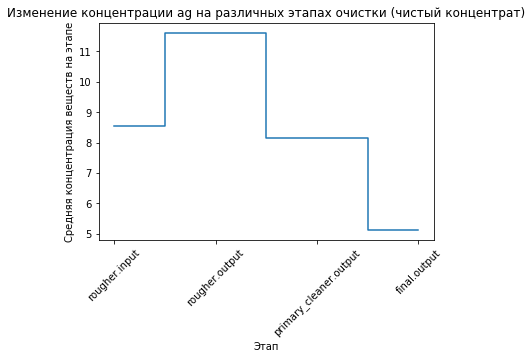

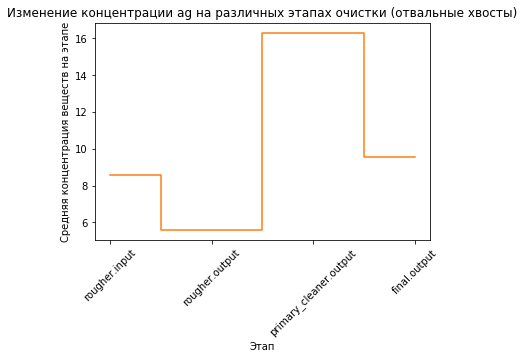


Корреляция признаков, содержащих информацию о концентрации ag на каждом этапе


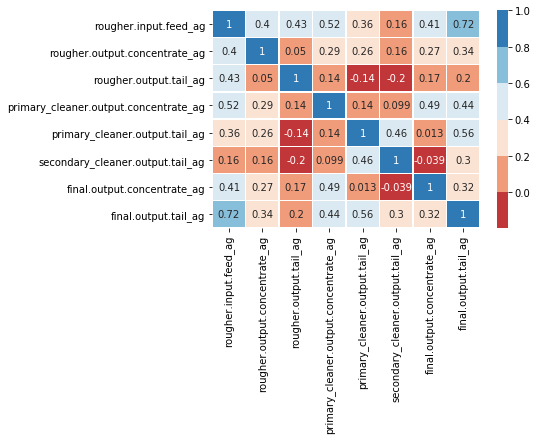

In [400]:
#выведем аналитические данные для серебра:    
print_metal_concentration_dynamic_print(gold_recovery_train,'ag')

Можно видеть, что концентрация серебра в чистом концентрате резко возрастает после этапа флотации, а затем довольно резко падает, и в финальном концентрате концентрация серебра очень низкая. В отвальных хвостах максимальная концентрация достигается после этапа первичной фильтрации, а после этапа окончательной фильтрации его доля чуть ниже. Это говорит о том, что разные этапы очень сильно влияют на концентрацию серебра. Для всех признаков среднее и медианное значение довольно близки. У всех признаков стандартное отклонение достаточно небольшое, и максимальные значения не похожи на аномальные<br>
Как и в случае с золотом, можем наблюдать сильную положительную связь между rougher.input.feed_ag и final.output.tail_ag. Связь rougher.input.feed с колонками с колонками concentrate выше, чем для золота. Здесь также наблюдается более сильная положительная связь между колонками .concentrate. Между колонками .tail здесь наблюдается довольно слабая связь. Связь между колонками .tail абсолютно разная: есть как близкая к сильной (primary_cleaner.output.tail_ag и final.output.tail_ag), так и слабая отрицательная связь(rougher.output.tail_ag и primary_cleaner.output.tail_ag). Это все говорит о том, что результаты для чистого концентрата более предсказуемы, а на то, что попадает в отвальные хвосты, воздействует большее количество факторов.

<h4>Анализ изменения концентрации свинца</h4>

Пример значения признаков


,rougher.input.feed_pb,rougher.output.concentrate_pb,rougher.output.tail_pb,primary_cleaner.output.concentrate_pb,primary_cleaner.output.tail_pb,secondary_cleaner.output.tail_pb,final.output.concentrate_pb,final.output.tail_pb
date,,,,,,,,
2016-01-15 00:00:00,2.284912,7.101074,0.508728,10.389648,2.534912,4.694824,9.889648,0.895447
2016-01-15 01:00:00,2.266033,7.278807,0.536689,10.497069,3.049646,4.592547,9.968944,0.927452
2016-01-15 02:00:00,2.159622,7.216833,0.546416,10.354494,3.124664,4.624775,10.213995,0.953716
2016-01-15 03:00:00,2.037807,7.175616,0.542525,8.496563,2.960362,4.482453,9.977019,0.883763
2016-01-15 04:00:00,1.786875,7.240205,0.515438,9.986786,3.112100,4.470737,10.142511,0.792826


Описательные статистики для признаков, содержащих информацию о концентрации металлов на каждом этапе


,rougher.input.feed_pb,rougher.output.concentrate_pb,rougher.output.tail_pb,primary_cleaner.output.concentrate_pb,primary_cleaner.output.tail_pb,secondary_cleaner.output.tail_pb,final.output.concentrate_pb,final.output.tail_pb
count,14547.000000,14547.000000,14547.000000,14547.000000,14547.000000,14547.000000,14547.000000,14547.000000
mean,3.493617,7.555537,0.654437,9.491745,3.450584,5.842486,10.052854,2.567528
std,1.111770,2.035432,0.272058,2.807967,1.509756,2.880250,1.836390,1.003334
min,0.008001,0.000000,0.007566,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.755062,6.767857,0.473198,8.243721,2.418902,3.975241,9.255991,1.872348
50%,3.405857,7.732853,0.625805,9.895425,3.225258,5.453296,10.269525,2.570471
75%,4.219946,8.587013,0.795594,11.284545,4.270766,7.809636,11.159128,3.235255
max,7.142594,18.394042,3.778064,17.081278,9.634565,17.042505,17.031899,5.639565


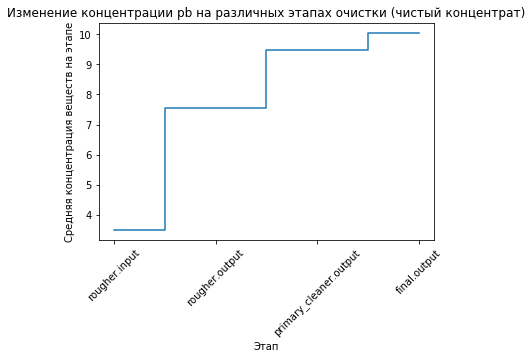

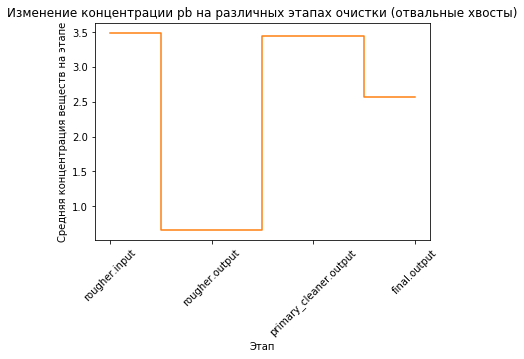


Корреляция признаков, содержащих информацию о концентрации pb на каждом этапе


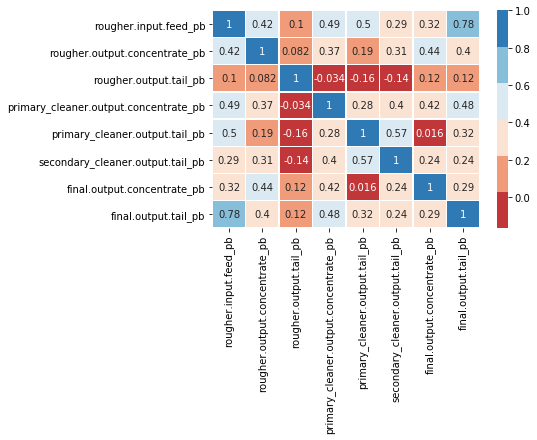

In [401]:
#выведем аналитические данные для серебра:    
print_metal_concentration_dynamic_print(gold_recovery_train,'pb')

Концентрация свинца на каждом этапе очистки в концентрате возрастает, однако с каждым этапом прирост этой концентрации уменьшается. В отвальных хвостах минимальная концентрация после процедуры флотации, после первичной очистки она резко возрастает и потом немного падает после вторичной очистки. Для всех признаков среднее и медианное значение очень близки, стандартные отклонения также достаточно низкие. <br>
Здесь также максимально высокая корреляция наблюдается для признаков rougher.input.feed_pb и final_output.tail_pb, при этом корреляция с признаком final_output.concentrate_pb почти в 2 раза ниже. Корреляция между rougher.input.feed_pb и признаками .concentrate 32-49%. Корреляция признаков .concentrate между собой 37-44%. корреляции признаков .tail между собой абсолютно разные: от очень слабой отрицательной связи до 61%. Это говорит о влиянии большего количества факторов на концентрацию свинца в отвальных хвостах.

<h4>Анализ долей содержания металлов на каждом этапе</h4>


Столбчатая диаграмма содержания металлов на каждом этапе в чистом концентрате



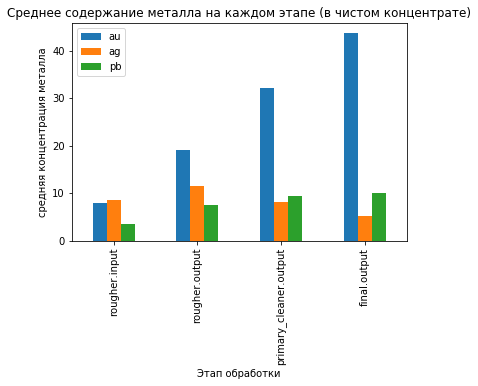


Столбчатая диаграмма содержания металлов на каждом этапе в отвальных хвостах



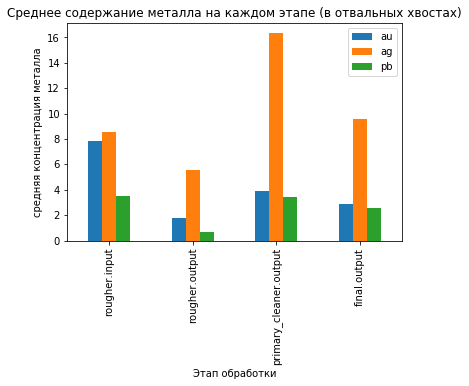

In [402]:
#Здесь вывести столбчатую диаграмму среднего количетсва металлов на каждом этапе
def print_plot(df,title):
    print()
    print('\033[1m'+'Столбчатая диаграмма содержания металлов на каждом этапе в '+title+'\033[0m')
    print()
    df.plot(kind = 'bar')
    
    plt.title('Среднее содержание металла на каждом этапе (в '+title+')')
    plt.xlabel('Этап обработки')
    plt.ylabel('средняя концентрация металла')
    plt.xticks(np.arange(4), df['steps'])
    plt.show()
def print_bar_metal(data):
    metals = ['au','ag','pb']
    step_columns = ['rougher.input','rougher.output','primary_cleaner.output','final.output']
    df_conc = pd.DataFrame({'steps':step_columns})
    df_tail = pd.DataFrame({'steps':step_columns})
    for metal in metals:
        data_means_conc = [data['rougher.input.feed_'+metal].mean(),data['rougher.output.concentrate_'+metal].mean(),data['primary_cleaner.output.concentrate_'+metal].mean(),data['final.output.concentrate_'+metal].mean()] 
        data_means_tail = [data['rougher.input.feed_'+metal].mean(),data['rougher.output.tail_'+metal].mean(),data['primary_cleaner.output.tail_'+metal].mean(),data['final.output.tail_'+metal].mean()]
        df_conc[metal] = data_means_conc
        df_tail[metal] = data_means_tail
    print_plot(df_conc,'чистом концентрате')
    print_plot(df_tail,'отвальных хвостах')
    
print_bar_metal(gold_recovery_train)        

На каждом этапе обработки доля золота в чистом концентрате заметно увеличивается, в то время как доля серебра постепенно снижается, концентрация свинца растет, но его доля заметно уменьшается, потому что значительно увелчивается концентрация золота.<br>
В отвальных хвостах ситуация обстоит немного иначе: после первичной очистки резко возрастает концентрация всех металлов(по сравнению с отвальными хвостами после флотации), после вторичной очистки их концентрация снова падает, однако, на всех этапах в отвальных хвостах самая высокая концентрация серебра по сравнению с остальными металлами; самая низкая - у свинца.

<h3>Анализ распределения гранул сырья на обучающей и тестовой выборке</h3>

Описательные статистики для датафреймов train и test


,train,test
count,14547.000000,5077.000000
mean,60.315544,55.024715
std,23.039030,14.761314
min,9.659576,0.046369
25%,48.961986,43.850534
50%,55.413104,50.277786
75%,66.417230,61.805597
max,484.967466,190.837404


Графики распределения  rougher.input.feed_size  для датафреймов train и test


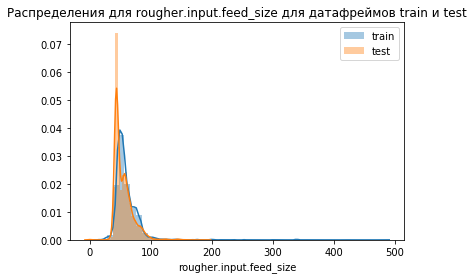

Диаграммы размаха для  rougher.input.feed_size  для датафреймов train и test


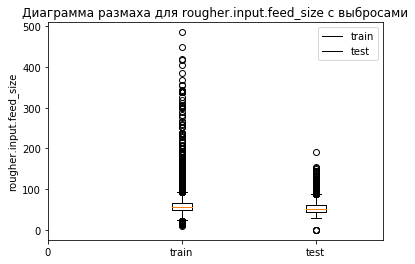

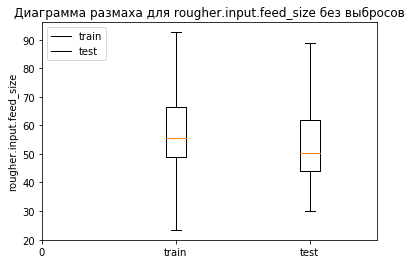

In [403]:
def print_boxplot(data1,data2, column,data1_name,data2_name,showflier):
    if showflier == True:
        tail = ' с выбросами'
    else:
        tail = ' без выбросов'    
    plt.boxplot([data1[column], data2[column]], showfliers = showflier)
    plt.title('Диаграмма размаха для '+column+tail)
    plt.legend([data1_name,data2_name])
    plt.xticks(np.arange(3),[0,data1_name,data2_name])
    plt.ylabel(column)
    plt.show()
def create_describes(data1,data2, column,data1_name,data2_name):
    describe1 = data1[column].describe()
    describe2 = data2[column].describe()
    decribes = pd.DataFrame({data1_name:describe1,data2_name:describe2})
    print('Описательные статистики для датафреймов '+data1_name+' и '+data2_name)
    display(decribes)

    
def print_distr(data1,data2, column,data1_name,data2_name):
    create_describes(data1,data2, column,data1_name,data2_name)
    print('Графики распределения ',column,' для датафреймов '+data1_name+' и '+data2_name)
    sns.distplot(data1[column], label = data1_name)
    sns.distplot(data2[column], label = data2_name)
    plt.title('Распределения для '+column+' для датафреймов '+data1_name+' и '+data2_name)
    plt.legend()
    plt.show()
    print('Диаграммы размаха для ',column,' для датафреймов '+data1_name+' и '+data2_name)
    print_boxplot(data1,data2, column,data1_name,data2_name,True)
    print_boxplot(data1,data2, column,data1_name,data2_name,False)
    
print_distr(gold_recovery_train,gold_recovery_test,'rougher.input.feed_size','train','test')

#print_distr(gold_recovery_test,'rougher.input.feed_size')

Как можно видеть, распределения гранул сырья на обучющей и тестовой выборке очень похожи. Все основные показатели очень близки по значению, погрешность может быть таже обусловлена разным размером выборок. Графики распределений практически накладываются друг на друга.Судя по графикам, а также досаточной близости среднего и медианного значений, распределения похожи на нормальное. Также на диаграммах размаха видно, что значения всех квартилей достаточно близки, также близки границы статистически значимой выборки. Погрешность все также может быть вызвана, в том числе, большой разницей в размерах выборки. <br>
Так как распределени не сильно отличаются друг от друга, то на этих данных можно проводить оценку модели

<h3>Исследование суммарной концентрации веществ на каждой стадии</h3>

In [404]:
def print_distplot_and_boxplot(data,data_name,stage_name):
    print('Диаграммы распределения для стадии '+stage_name+' на выборке '+data_name)
    plt.subplot(1,2,1)
    plt.hist(data)
    plt.xlabel('Общая концентрация металлов')
    plt.ylabel('Количество значений')
    plt.title('Гистограмма')
    plt.subplot(1,2,2)
    plt.boxplot(data, showfliers = True)
    plt.title('Диаграмма размаха')
    plt.tight_layout()
    plt.show()
    quantile_1 = data.quantile(q=0.25)
    quantile_2 = data.quantile(q=0.75)
    print('Границы статистически значимой выборки: ',quantile_1 - 1.5*(quantile_2 - quantile_1),' - ',quantile_2 + 1.5*(quantile_2 - quantile_1))
    
def count_sum_concentrate(data1,data2, stage,data1_name,data2_name,stage_name):
    au_conc_col = stage+'au'
    ag_conc_col = stage+'ag'
    pb_conc_col = stage+'pb'
    total_conc_col = 'total_'+stage+'_conc'
    if not (data2 is None):
        data1[total_conc_col] = data1[au_conc_col] + data1[ag_conc_col] +data1[pb_conc_col]
        data2[total_conc_col] = data2[au_conc_col] + data2[ag_conc_col] +data2[pb_conc_col]
        create_describes(data1,data2, total_conc_col,data1_name,data2_name)
        print()
        print('\033[1m'+'Диаграммы распределения на выборке '+data1_name+'\033[0m')
        print_distplot_and_boxplot(data1[total_conc_col],data1_name,stage_name)
        print()
        print('\033[1m'+'Диаграммы распределения на выборке '+data2_name+'\033[0m')
        print_distplot_and_boxplot(data2[total_conc_col],data2_name,stage_name)
    else:
        data1[total_conc_col] = data1[au_conc_col] + data1[ag_conc_col] +data1[pb_conc_col]
        print('Описательная статистика для ',data1_name,' на этапе ',stage_name)
        display(data1[total_conc_col].describe())
        print()
        print('\033[1m'+'Диаграммы распределения на выборке '+data1_name+'\033[0m')
        print_distplot_and_boxplot(data1[total_conc_col],data1_name,stage_name)


<h4>Исследование суммарной концентрации металлов в исходном сырье</h4>

Описательные статистики для датафреймов train и test


,train,test
count,14547.000000,5077.000000
mean,19.885753,22.665066
std,4.594155,3.976209
min,0.030000,5.503477
25%,16.824003,20.184532
50%,19.181502,23.123084
75%,22.564247,25.193813
max,32.847158,33.498784



Диаграммы распределения на выборке train
Диаграммы распределения для стадии исходное сырье на выборке train


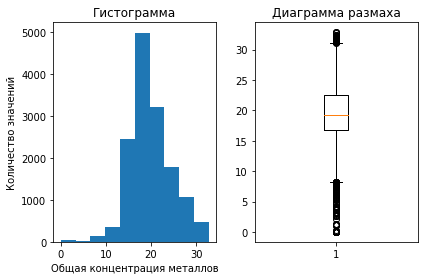

Границы статистически значимой выборки:  8.213638030867333  -  31.17461233188671

Диаграммы распределения на выборке test
Диаграммы распределения для стадии исходное сырье на выборке test


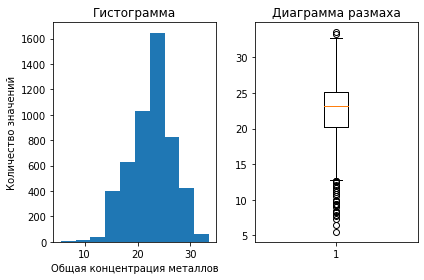

Границы статистически значимой выборки:  12.670610748490299  -  32.707734938714516


In [405]:
#рассмотрим распределение общей концентрации на стадии исходного сырья    
count_sum_concentrate(gold_recovery_train,gold_recovery_test,'rougher.input.feed_','train','test','исходное сырье')

<b>Вывод</b><br>
Судя по гистограммам, распределения очень похожи на нормальные. Однако, в тренировочной выборке заметен небольшой всплеск около нулевых значений. Эти значения не входят в границы статитистически значимой выборки, и, скорее всего, при таких значениях исходных данных значения на всех остальных этапах также будут близки к нулю. Полагаю, необходимо исключить такие аномальные данные, потому что они не несут особой ценности(как правило, на вход подается все-таки более качественное сырье), а также могут быть причиной переобучения модели.
На тестовой выборке таких аномальных всплесков нет

<h4>Исследование суммарной концентрации металлов после флотации</h4>

Описательная статистика для  train  на этапе  после флотации


count    14547.000000
mean        38.304723
std          8.132903
min          0.000000
25%         37.773345
50%         39.780916
75%         41.761143
max         55.568687
Name: total_rougher.output.concentrate__conc, dtype: float64


Диаграммы распределения на выборке train
Диаграммы распределения для стадии после флотации на выборке train


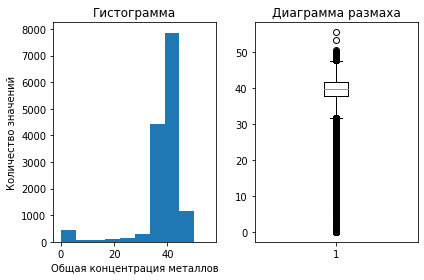

Границы статистически значимой выборки:  31.79164864276617  -  47.74283928828873


In [406]:
#рассмотрим распределение общей концентрации после флотации    
count_sum_concentrate(gold_recovery_train,None,'rougher.output.concentrate_','train','test','после флотации')

<b>Вывод</b><br>
Здесь также обнаруживается заметный всплеск около нулевых значений (потому что такие значения были обнаружены в исходном сырье). Эти значения не входят в границы статистической значимости, но могут приводить модель к переобучению.

<h4>Исследование суммарной концентрации металла в черновом концентрате</h4>

Описательная статистика для  train  на этапе  черновой концентрат


count    14547.000000
mean        49.823121
std          8.739859
min          0.000000
25%         49.542687
50%         51.741382
75%         53.416165
max         60.269003
Name: total_primary_cleaner.output.concentrate__conc, dtype: float64


Диаграммы распределения на выборке train
Диаграммы распределения для стадии черновой концентрат на выборке train


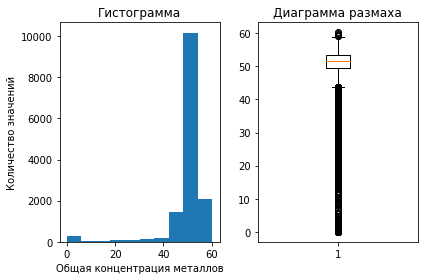

Границы статистически значимой выборки:  43.73246989844147  -  59.22638184970719


In [407]:
#рассмотрим распределение общей концентрации в черновом концентрате   
count_sum_concentrate(gold_recovery_train,None,'primary_cleaner.output.concentrate_','train','test','черновой концентрат')

<b>Вывод</b><br>
Здесь также обнаруживается заметный всплеск около нулевых значений (потому что такие значения были обнаружены в исходном сырье), а также довольно длинный "хвост" ниже нижней границы статистической значимости (что также может являться следствием низких входных значений). Эти значения не входят в границы статистической значимости, но могут приводить модель к переобучению.

<h4>Исследование суммарной концентрации металлов в финальном концентрате</h4>

Описательная статистика для  train  на этапе  финальный концентрат


count    14547.000000
mean        58.843744
std          7.445616
min          0.000000
25%         59.158820
50%         60.240525
75%         61.050918
max         64.968881
Name: total_final.output.concentrate__conc, dtype: float64


Диаграммы распределения на выборке train
Диаграммы распределения для стадии финальный концентрат на выборке train


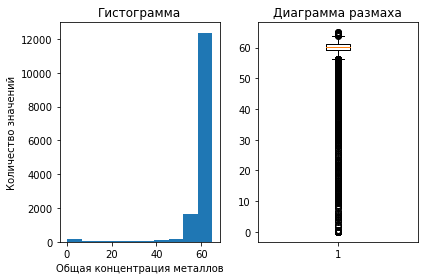

Границы статистически значимой выборки:  56.32067252422167  -  63.889065929928684


In [408]:
#рассмотрим распределение общей концентрации в черновом концентрате   
count_sum_concentrate(gold_recovery_train,None,'final.output.concentrate_','train','test','финальный концентрат')

<b>Вывод</b><br>
Здесь также обнаруживается заметный всплеск около нулевых значений (потому что такие значения были обнаружены в исходном сырье), а также довольно длинный "хвост" ниже нижней границы статистической значимости (что также может являться следствием низких входных значений). Эти значения не входят в границы статистической значимости, но могут приводить модель к переобучению.<br>
В целом можно видеть, что небольшой всплеск около нулевых значений в исходном сырье(то есть сырье с нулевой (или близкой к нулевой) концентрцией) приводит к тому, что такой всплеск аномальных значений тянется на всех этапах. <br>
Мы можем видеть, что "хвост" низких значений концентрации с каждым этапом все длиннее. То есть лишь небольшое количество экспериментов привело к тому, что в финальном концентрате действительно выская концентрация сырья. <br>
Ввиду того, что при нулевых или очень низких входных данных мы в любом случае получим нулевые или же очень низкие результирующие данные, поэтому их можно удалить. Они не несут в себе никакой информации, и могут лишь приводить модель к переобучению. 

<h4>Удаление аномалий</h4>

Удалим из _train выборки все строки, где суммарная концентрация металлов в исходном сырье < 0.05% , а также те строки, где просто исходная концентрация золота - нулевая. Как можно видеть, нижняя граница статистической значимости у данных по исходному сырью проходит у свыше 8%, однако,так или иначе туда попадает довольно большое количество значений, которые могут быть важны при построении модели. 

In [409]:
stages = ['rougher.input.feed_','rougher.output.concentrate_','primary_cleaner.output.concentrate_','final.output.concentrate_']
for stage in stages:
    #выделим строки, которые будем удалять
    gold_recovery_train['to_delete'] = np.where((gold_recovery_train[stage+'au'] + gold_recovery_train[stage+'ag'] + gold_recovery_train[stage+'pb']) < 0.5,1,0)
    gold_recovery_train['to_delete'] = np.where((gold_recovery_train[stage+'au']) == 0,1,0)
    #удалим ненужные строки
    gold_recovery_train = gold_recovery_train[gold_recovery_train['to_delete'] == 0]
#удалим вспомогательные столбец
gold_recovery_train = gold_recovery_train.drop('to_delete',axis = 1)
print('Размер датафрейма после удаления: ',gold_recovery_train.shape)

Размер датафрейма после удаления:  (14059, 91)


Проверим распределения после удаления столбцов:

Диаграммы распределения для стадии rougher.input.feed_ на выборке train


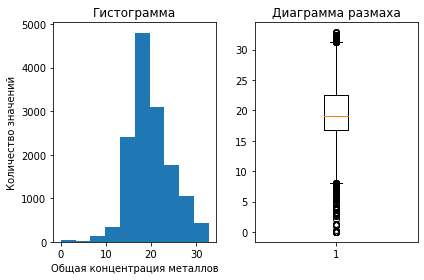

Границы статистически значимой выборки:  8.109421047632642  -  31.298767785347742

Диаграммы распределения для стадии rougher.output.concentrate_ на выборке train


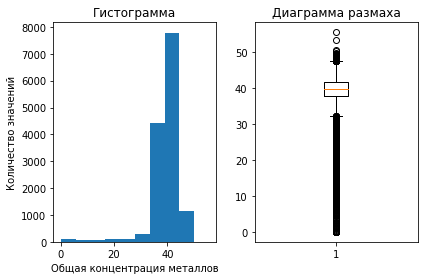

Границы статистически значимой выборки:  32.19212200584574  -  47.56430287833363

Диаграммы распределения для стадии primary_cleaner.output.concentrate_ на выборке train


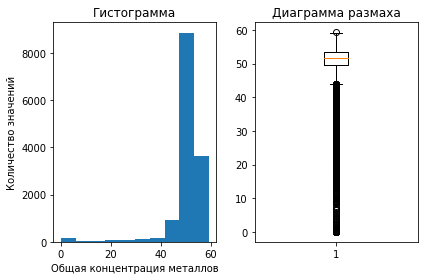

Границы статистически значимой выборки:  43.90445341930323  -  59.079225962899706

Диаграммы распределения для стадии final.output.concentrate_ на выборке train


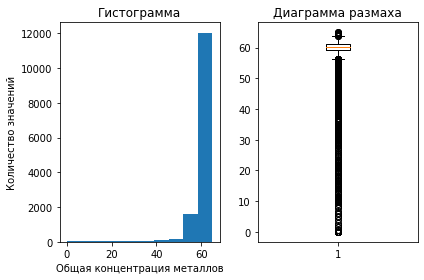

Границы статистически значимой выборки:  56.385787134793205  -  63.83372142658105

Размер датафрейма после удаления:  (14059, 87)


In [410]:
stages = ['rougher.input.feed_','rougher.output.concentrate_','primary_cleaner.output.concentrate_','final.output.concentrate_']
for stage in stages:
    total_conc_col = 'total_'+stage+'_conc'
    stage_au =stage+'au'
    gold_recovery_train[total_conc_col] = gold_recovery_train[stage+'au'] + gold_recovery_train[stage+'ag'] + gold_recovery_train[stage+'pb']
    print_distplot_and_boxplot(gold_recovery_train[total_conc_col],'train',stage)
    #удлим вспомогательные столбцы
    gold_recovery_train = gold_recovery_train.drop(total_conc_col,axis = 1)
    print()
print('Размер датафрейма после удаления: ',gold_recovery_train.shape)

<b>Вывод</b><br>
Удалены все всплески около нуля, однако можно видеть, что остались еще довольно большие "хвосты" у всех распределений на различных этапах переработки. Удалять их не нужно, так как они являются результатом переработки сырья с нормальной концентрацией металлов. <br>
Данные готовы к построению модели

## Модель

<h3>Функция для расчета итогового sMAPE</h3>

In [411]:
def smape(target,predictions): #функция для расчета smape
    smape_sum = 0
    predictions = pd.Series(predictions,index=target.index)
    for i in target.index.values:
        middle_result = np.abs(target[i] - predictions[i]) / (2*(np.abs(target[i]) + np.abs(predictions[i])))
        smape_sum += middle_result
    smape = (smape_sum / len(target))
    return smape * 100
def total_smape(target_rougher,predictions_rougher,target_final,predictions_final): #функция для расчета итогового smape
    smape_rougher = smape(target_rougher,predictions_rougher)
    smape_final = smape(target_final,predictions_final)
    total_smape = 0.25 * smape_rougher + 0.75 * smape_final
    return total_smape 
    

<h3>Построение моделей</h3>

<h4>Функции для построения моделей</h4>

<b>Функция для создания и обучения модели, получения предсказания:</b>

In [412]:
def make_model(features_train,target_train,features_valid,target_valid, depth, estimators,model_type):
    if model_type == 'LR':
        model = LinearRegression()
    elif model_type == 'DT':
        model = DecisionTreeRegressor(random_state = RANDOM_STATE, max_depth = depth)
    elif model_type == 'RF':
        model = RandomForestRegressor(random_state = RANDOM_STATE, max_depth = depth, n_estimators = estimators)
    model.fit(features_train,target_train)
    predictions = model.predict(features_valid)
    return model,predictions    


<b>Функции для построения моделей с оптимальными гиперпараметрами:</b>

функция для построения модели линейной регрессии и расчета score (total sMAPE)

In [413]:
def find_LinearModel_score(features_rougher_train,target_rougher_train, 
                           features_rougher_valid,target_rougher_valid,
                           features_full_train,target_full_train,
                           features_full_valid,target_full_valid):

    model_rougher, predictions_rougher = make_model(features_rougher_train,target_rougher_train,features_rougher_valid,target_rougher_valid, None, None, 'LR')
    model_full, predictions_full = make_model(features_full_train,target_full_train,features_full_valid,target_full_valid, None, None, 'LR')
    score = total_smape(target_rougher_valid,predictions_rougher,target_full_valid,predictions_full)
    return score, model_full, predictions_full, model_rougher, predictions_rougher

Функция для построения модели дерева решений с оптимальным значением depth

In [414]:
def find_DecisionTree_score(features_rougher_train,target_rougher_train,
                           features_rougher_valid,target_rougher_valid,
                           features_full_train,target_full_train,
                           features_full_valid,target_full_valid):
    best_score = 100   
    for depth in range(1,100):
        model_rougher, predictions_rougher = make_model(features_rougher_train,target_rougher_train,features_rougher_valid,target_rougher_valid,depth,None,'DT')
        model_full, predictions_full = make_model(features_full_train,target_full_train,features_full_valid,target_full_valid,depth,None,'DT')
        score = total_smape(target_rougher_valid,predictions_rougher,target_full_valid,predictions_full)
        if score < best_score:
            best_score = score
            best_model_full = model_full
            best_predictions_full = predictions_full
            best_model_rougher = model_rougher
            best_predictions_rougher = predictions_rougher
    return best_score, best_model_full, best_predictions_full, best_model_rougher, best_predictions_rougher

Функция для построения модели леса решений с оптимальными гиперпараметрами max_depth и e_estimators

In [415]:
def find_RandomForest_score(features_rougher_train,target_rougher_train,
                           features_rougher_valid,target_rougher_valid,
                           features_full_train,target_full_train,
                           features_full_valid,target_full_valid):
    best_score = 100
    #найдем ниалучшую глубину на малом количестве деревьев
    for depth in range(1,100):
        model_rougher, predictions_rougher = make_model(features_rougher_train,target_rougher_train,features_rougher_valid,target_rougher_valid,depth,10,'RF')
        model_full, predictions_full = make_model(features_full_train,target_full_train,features_full_valid,target_full_valid,depth,10,'RF')
        score = total_smape(target_rougher_valid,predictions_rougher,target_full_valid,predictions_full)
        if score < best_score:
            best_score = score
            best_depth = depth
    #найдем наилучшее количество деревьев
    best_score = 100
    for estim in range(10,100,10):
        model_rougher, predictions_rougher = make_model(features_rougher_train,target_rougher_train,features_rougher_valid,target_rougher_valid,best_depth,estim,'RF')
        model_full, predictions_full = make_model(features_full_train,target_full_train,features_full_valid,target_full_valid,best_depth,estim,'RF')
        score = total_smape(target_rougher_valid,predictions_rougher,target_full_valid,predictions_full)
        if score < best_score:
            best_score = score
            best_model_full = model_full
            best_predictions_full = predictions_full
            best_model_rougher = model_rougher
            best_predictions_rougher = predictions_rougher
    return best_score, best_model_full, best_predictions_full, best_model_rougher, best_predictions_rougher

<h4>Построение моделей и проверка их качества кросс-валидацией</h4>

Переиндексируем датафреймы

In [416]:
def df_reindex(data):
    data = data.drop('date',axis = 1)
    data = data.reset_index()
    data.rename({'index':'date'},axis = 'columns',inplace = True)
    print(data.info())
    return data
gold_recovery_train = df_reindex(gold_recovery_train)   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14059 entries, 0 to 14058
Data columns (total 87 columns):
date                                                  14059 non-null datetime64[ns]
final.output.concentrate_ag                           14059 non-null float64
final.output.concentrate_pb                           14059 non-null float64
final.output.concentrate_sol                          14059 non-null float64
final.output.concentrate_au                           14059 non-null float64
final.output.recovery                                 14059 non-null float64
final.output.tail_ag                                  14059 non-null float64
final.output.tail_pb                                  14059 non-null float64
final.output.tail_sol                                 14059 non-null float64
final.output.tail_au                                  14059 non-null float64
primary_cleaner.input.sulfate                         14059 non-null float64
primary_cleaner.input.depressant     

По условию нам необходимо предсказать эффективность на двух этапах: после флотации и после вторичной очистки. Для того, чтобы отдельно предсказать эффективность после флотации, небходимо выделить соответсвующие колонки в отдельный датасет и для них отдельно делать предсказание. <br>
Напишем функции создания нового датафрема из части признаков старого.


In [417]:
def change_columns_list(data,part_column_name, target):
    columns_part = []
    columns_excl = []
    for column in data:
        if column.find(part_column_name) >=0:
            columns_part.append(column)
        else:
            columns_excl.append(column)
    if target == 'part':
        res_data = data[columns_part]
    elif target == 'excl':
        res_data = data[columns_excl]
        
    return res_data

rougher_columns = change_columns_list(gold_recovery_train,'rougher','part')
#выведем общую информацию о полученном датафрейме:
print(rougher_columns.shape)

(14059, 35)


Выделим в датафреймах целевые признаки. Известно, что в тестовом датфрейме отсутствуют все колонки output и calculation. Уберем их их из построения модели. 

In [418]:
#выделим целевой признак и обучающие признаки для rougher.output.recovery
target_rougher = rougher_columns['rougher.output.recovery']
features_rougher = rougher_columns.drop(['rougher.output.recovery'],axis = 1)

features_rougher_like_test = change_columns_list(features_rougher,'output','excl')
features_rougher_like_test = change_columns_list(features_rougher_like_test,'calculation','excl')

#выделим целевой признак и обучающие признаки для final.output.recovery
target_full = gold_recovery_train['final.output.recovery']
features_full = gold_recovery_train.drop(['date','rougher.output.recovery','final.output.recovery'],axis = 1)
features_full_like_test = change_columns_list(features_full,'output','excl')
features_full_like_test = change_columns_list(features_full_like_test,'calculation','excl')


Напишем функции нахождения оптимальной модели:

In [419]:
def get_valid_train(features,target,train_indexes,valid_indexes):#разделяем на тренировочную и валиационную выборки
    features_train = features.loc[features.index.isin(train_indexes)]
    features_valid = features.loc[features.index.isin(valid_indexes)]
    target_train = target.loc[target.index.isin(train_indexes)]
    target_valid = target.loc[target.index.isin(valid_indexes)]
    return features_train,features_valid,target_train,target_valid

#функция для применения кровсс-валидации для оценки качества заданной модели
def cross_val_LinearRegression(data, target_rougher, features_rougher, target_full, features_full,model_type):
    scores = []
    sample_size = int(len(data)/5)
    step_nmb = 0
    index_arr = data.index.values 
    for i in range(0, len(data), sample_size):
        valid_indexes = index_arr[i:i+sample_size]
        train_indexes = np.delete(index_arr,valid_indexes)
        
        features_rougher_train,features_rougher_valid,target_rougher_train,target_rougher_valid = get_valid_train(features_rougher,target_rougher,train_indexes,valid_indexes)
        features_full_train,features_full_valid,target_full_train,target_full_valid = get_valid_train(features_full,target_full,train_indexes,valid_indexes)
        
        if step_nmb == 0:
            if model_type == 'LR':
                score, model_full, predictions_full, model_rougher, predictions_rougher = find_LinearModel_score(features_rougher_train,target_rougher_train,features_rougher_valid,target_rougher_valid,features_full_train,target_full_train,features_full_valid,target_full_valid)  
            elif model_type == 'DT':
                score, model_full, predictions_full, model_rougher, predictions_rougher = find_DecisionTree_score(features_rougher_train,target_rougher_train,features_rougher_valid,target_rougher_valid,features_full_train,target_full_train,features_full_valid,target_full_valid)  
            elif model_type == 'RF':
                score, model_full, predictions_full, model_rougher, predictions_rougher = find_RandomForest_score(features_rougher_train,target_rougher_train,features_rougher_valid,target_rougher_valid,features_full_train,target_full_train,features_full_valid,target_full_valid)            
            step_nmb += 1
        else:
            rougher_predictions = model_rougher.predict(features_rougher_valid)
            full_predictions = model_full.predict(features_full_valid)
            score = total_smape(target_rougher_valid,rougher_predictions,target_full_valid,full_predictions)
    scores.append(score)
    final_score = np.mean(scores)
    print('Оценка качества модели: {:2f}%'.format(final_score))
    return model_rougher, model_full
     
        
    

<h4>Стандартизация данных</h4>

напишем функцию стандартизации

In [420]:
def standartize(data_train):
    indexes = data_train.index
    data_train2 = data_train
    scaler = StandardScaler()
    scaler.fit(data_train2)
    data_train_standatrized = pd.DataFrame(scaler.transform(data_train2),index= indexes)
    return data_train_standatrized,scaler

стандартизируем признаки

In [421]:
features_rougher_like_test, scaler_rougher = standartize(features_rougher_like_test)
features_full_like_test, scaler_full = standartize(features_full_like_test)

<h4>Оценка различых моделей</h4>

Оценим модели линейной регрессии

In [423]:
print('Оценка модели линейной регрессии на данных без output столбцов')
LR_LT_model_rougher, LR_LT_model_full =cross_val_LinearRegression(gold_recovery_train, target_rougher, features_rougher_like_test, target_full, features_full_like_test,'LR')

Оценка модели линейной регрессии на данных без output столбцов
Оценка качества модели: 44.780051%


Оценим модели дерева решений

In [424]:
print('Оценка модели дерева решений на данных без output столбцов')
DT_LT_model_rougher, DT_LT_model_full =cross_val_LinearRegression(gold_recovery_train, target_rougher, features_rougher_like_test, target_full, features_full_like_test,'DT')

Оценка модели дерева решений на данных без output столбцов
Оценка качества модели: 0.762104%


Оценим модели лес решений

In [425]:
print('Оценка модели лес решений на данных без output столбцов')
FR_LT_model_rougher, FR_LT_model_full = cross_val_LinearRegression(gold_recovery_train, target_rougher, features_rougher_like_test, target_full, features_full_like_test,'RF')

Оценка модели лес решений на данных без output столбцов
Оценка качества модели: 0.472589%


Наилучшая модель - модель с самым низким значением итогового sMAPE - это модель лес решений. Проверим ее на тестовой выборке

<h4>Проверка лучшей модели на тестовой выборке</h4>

Для оценки качества предсказания получим значения целевого признака из полной выборки и подготовим признаки из тестовой выборки:

In [426]:
#выделяем целевые признаки
target_rougher = gold_recovery_full_test['rougher.output.recovery']
target_full = gold_recovery_full_test['final.output.recovery']
try:
    gold_recovery_test = gold_recovery_test.drop(['date','total_rougher.input.feed__conc'],axis = 1)
except:
    print('Ненужные столбцы уже удалены')
#выделим features:
#gold_recovery_test = gold_recovery_test.drop(['date'],axis = 1)
features_rougher = change_columns_list(gold_recovery_test,'rougher','part')
print('Информация о features_rougher')
print(features_rougher.shape)
print()
print('Информация о features_final')
features_final = gold_recovery_test
print(gold_recovery_test.shape) 

#стандартизируем
rougher_index = features_rougher.index
features_rougher2 = features_rougher
features_rougher = pd.DataFrame(scaler_rougher.transform(features_rougher2),index = rougher_index)


full_index = features_final.index
features_final2 = features_final
features_final = pd.DataFrame(scaler_full.transform(features_final2),index = full_index)

Информация о features_rougher
(5077, 22)

Информация о features_final
(5077, 52)


Проверим лучшую модель на тестовой выборке:

In [427]:
predictions_rougher = FR_LT_model_rougher.predict(features_rougher)
predictions_full =  FR_LT_model_full.predict(features_final)
print('Оценка качества: {:2f}%'.format(total_smape(target_rougher,predictions_rougher,target_full,predictions_full)))

Оценка качества: 16.839396%


Качество лучшей модели на тестовой выборке ниже, чем на обучающей выборке. Это говорит о преобучении модели.  